# Image Analysis Challenge (Part 2)
Developed by:

**Ahmed Gouda, MAIA**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''Importing required packages'''
import nibabel as nib
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from skimage.morphology import remove_small_objects
from sklearn.cluster import KMeans

In [ ]:
'''Load fuctions'''

'''This functions removes connected pixels intensities more than spescific threshold and the small connected objects from a binary mask less than specific size.'''
def undesired_objects (image, image_mask, threshold_val, min_size_val):
    components, n = ndimage.label( image_mask )
    #Remove the small objects.
    components = remove_small_objects(components, min_size = min_size_val)
    #Set labels for the new connected objects. 
    components, n = ndimage.label(components)
    for i in range(0,n+1):
      component_compress = image[components==i]
      component_avg = np.sum(component_compress)/np.shape(component_compress)
      #Convert the components into a mask. 
      if(component_avg>threshold_val):
        components[components==i] = 0;
    components[components>0] = 1
    return(components)

'''This function sets the back ground invert mask to zero'''
def remove_background ( image ):
    #Split the connected objects into different labels.
    components, n = ndimage.label( image )
    #Set the background components into zeros which holds the same corner labels values.
    components[components == components[0][0]] = 0
    components[components == components[components.shape[0]-1][0]] = 0
    components[components == components[0][components.shape[1]-1]] = 0
    components[components == components[components.shape[0]-1][components.shape[1]-1]] = 0
    #Convert the components into a mask.
    components[components > 0]  = 1
    return(components)

'''This function applies hounsfield windowing a certain level and window width.'''
def hounsfield_window ( image,  level, width):
    #Calculate the minimum and maximum window threshold value.
    min_win = level - (int)(width/2)
    max_win = level + (int)(width/2)
    #Apply the min and max threshold to the image.
    image[image<min_win] = min_win
    image[image>max_win] = max_win
    return(image)    
    
'''This function applies image thresholding within a minimum and a maximum range.'''
def image_thershold(image, min_val, max_val):
  image[image<min_val] = min_val
  image[image>max_val] = min_val
  image = image - min_val;
  image[image > 0] = 1
  return(image) 

# 1) Running the Algorithm 



In [ ]:
#Scan all the images from the directory
scan_dir = '/content/drive/MyDrive/Colab Notebooks/LungTechChallenge/Images/'
scan_files = [f for f in listdir(scan_dir) if 'nii' in f]
scan_files = np.sort(scan_files)
vessels_lung_ratio_feat = np.zeros((scan_files.shape[0],1), dtype=np.float32)
for i, f in enumerate(scan_files[0::]):
  print('Loading Image: '+ f)
  img_CT = nib.load(scan_dir + f)
  img_data = np.transpose(img_CT.get_fdata())

  #Set the Hounsfield window settings: level=-600HU and width=1000HU (between -1100 HU and  -100HU) just to show the image.
  img_hu_win1 = hounsfield_window(np.copy(img_data), level = -600, width = 1000)

  '''The first lung border invert segmentation mask'''
  #Segment all the tissues and the bones that surrounds the lung within the range 700 and 1000. 
  img_data_mask1 = 1 - image_thershold(np.copy(img_data), -400, np.amax(img_data))

  #Apply close mophilogical operation to remove the scanner bed borders.
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
  img_data_mask1_close =  cv2.morphologyEx(img_data_mask1, cv2.MORPH_CLOSE, kernel)

  #Remove the background image and get the lung invert mask.
  im_inv_mask_lung_border = remove_background (img_data_mask1_close)

  '''The second trachea segmentation mask'''
  #Segment all the tissues and the bones that surrounds the lung within the range 700 and 1000. 
  img_data_mask2 = np.copy(img_data)
  img_data_mask2[img_data_mask2>-700] = 1;
  img_data_mask2[img_data_mask2<=-700] = 0;
  img_data_mask2 = 1-img_data_mask2

  #Remove the backgound using the first invert lung border mask.
  img_data_mask2_mul = im_inv_mask_lung_border * img_data_mask2

  #Fill the holes.
  img_data_mask2_mul_fill = ndimage.binary_fill_holes(img_data_mask2_mul).astype(int)

  #Remove the connected objects > -925 HU and the small connected pixels.
  im_inv_mask_trachea = 1 - undesired_objects (np.copy(img_data), np.copy(img_data_mask2_mul_fill), -925, 100)

  '''The third lung segmentation mask'''
  img_data_mask3 =image_thershold(np.copy(img_data), -1100, -400)

  ''' Multiply the three masks to get the final lung mask.''' 
  im_mask_lung = im_inv_mask_lung_border * img_data_mask3 * im_inv_mask_trachea

  '''Apply post-processing'''
  #Close the objects.
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
  im_mask_lung_open =  cv2.morphologyEx(np.uint8(im_mask_lung), cv2.MORPH_OPEN, kernel)

  #Close the objects.
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 7))
  im_mask_lung_open_close =  cv2.morphologyEx(np.uint8(im_mask_lung_open), cv2.MORPH_CLOSE, kernel)
  
  #Fill the holes after closing and get the finalmask.
  im_mask_lung_final = ndimage.binary_fill_holes(im_mask_lung_open_close).astype(int)

  '''Segment the vessels'''
  #Extract the lung reigon from the mask.
  img_data_lung = np.copy(img_data)
  img_data_lung[im_mask_lung_final==0] = np.amin(img_data_lung)

  #Remove the values less than -500
  im_mask_vessels = np.copy(img_data_lung)
  im_mask_vessels[im_mask_vessels <-500] = -500

  #Segment the vessels
  im_mask_vessels = im_mask_vessels + 500
  im_mask_vessels[im_mask_vessels > 0] = 1

  plt.figure(figsize=(20, 20))
  plt.subplot(131),plt.imshow(img_data, cmap = 'gray')
  plt.title('The original image.',fontsize=20)
  plt.subplot(132),plt.imshow(img_hu_win1, cmap = 'gray'), plt.imshow(im_mask_lung_final, cmap = 'jet', alpha=0.7)
  plt.title('The segmented lung mask.',fontsize=20)
  plt.subplot(133), plt.imshow(im_mask_vessels, cmap = 'gray')
  plt.title('The segmented vessels.',fontsize=20)
  plt.show()

  '''Save the final lung mask'''
  save_dir = '/content/drive/MyDrive/Colab Notebooks/LungTechChallenge/Output_masks/Lung_masks/'
  #Set the mask header file similar to the original header file. 
  img_CT_lung_mask = nib.Nifti1Image(np.transpose(im_mask_lung_final), img_CT.affine, img_CT.header)
  nib.save(img_CT_lung_mask, save_dir + f[0:8]+'_lung_mask.nii.gz')

  '''Save the final vessels mask'''
  save_dir = '/content/drive/MyDrive/Colab Notebooks/LungTechChallenge/Output_masks/Vessels_masks/'
  #Set the mask header file similar to the original header file. 
  img_CT_vessels_mask = nib.Nifti1Image(np.transpose(im_mask_vessels), img_CT.affine, img_CT.header)
  nib.save(img_CT_vessels_mask, save_dir + f[0:8]+'_vessels_mask.nii.gz')

  '''Compute the lung area in mm²'''
  #Calculate the lung area by summing up all mask pixels and multipling the result by the pixels dimentions.
  lung_area = np.sum(im_mask_lung_final)*img_CT.header['pixdim'][1]*img_CT.header['pixdim'][2]
  print('The lung area is ' + str(lung_area) + ' mm²')

  '''Calculate vessel-lung area ratio'''
  vessels_lung_ratio = np.sum(im_mask_vessels)*100/np.sum(im_mask_lung_final)
  print('The vessel-lung area ratio is ' + str(vessels_lung_ratio) + '%') 

  vessels_lung_ratio_feat[i][0] = vessels_lung_ratio


Output hidden; open in https://colab.research.google.com to view.

# 2) Unsupervised Vessels-Lung Ratio Clustring Using K-Means

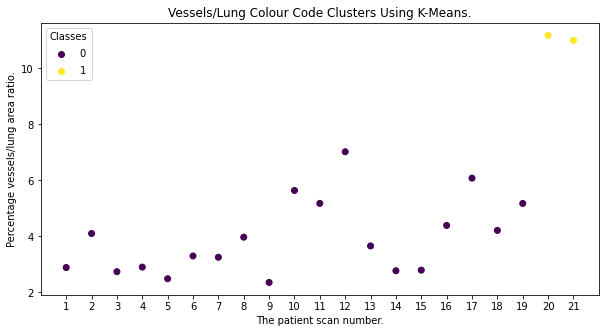

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(vessels_lung_ratio_feat)
pred_clusters = kmeans.labels_

patient_scan = np.arange(1, vessels_lung_ratio_feat.shape[0]+1, step=1)
fig, ax = plt.subplots(figsize=(10, 5))
plt.xticks(patient_scan)
scatter = ax.scatter(patient_scan, vessels_lung_ratio_feat, c=pred_clusters)
legend = ax.legend(*scatter.legend_elements(),loc="upper left", title="Classes")
plt.title('Vessels/Lung Colour Code Clusters Using K-Means.')
plt.xlabel('The patient scan number.')
plt.ylabel('Percentage vessels/lung area ratio.') 
plt.show()